# Experiment Run

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [294]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import KMeans

import vis
import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [241]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions,True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 166.81it/s]


Remove 559 out of 128484 datapoints.


## Experiment

In [242]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"]==0.0]["type_name"] )
action_types = set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"}
action_types

{'clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in'}

### Location mixture: Number of clusters calibration

In [243]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type) #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]]

    # Inner loop over number of clusters
    for K in range(2, 16):
        print(f" {K} clusters,", end="")
        gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]
        loc_model = sc.MixtureModel(gauss_clusters)
        # In the case of an failed initialization due to empty clusters, skip that model.
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                loc_model.fit_em_bregman(loc_data, verbose=False)
            except ConvergenceWarning as e:
                print(f"    Skipping K={K} due to convergence warning: {e}")
                continue   # skip straight to the next K
        rows.append({
            "action_type": action_type,
            "cluster_nbr": K,
            "ch_score": loc_model.kl_ch_score(loc_data),
            "bic_score" : loc_model.bic_score(loc_data),
            "aic_score" : loc_model.aic_score(loc_data)
        })

loc_scores = pd.DataFrame(rows)


Processing throw_in:
 2 clusters, 3 clusters, 4 clusters, 5 clusters, 6 clusters, 7 clusters, 8 clusters, 9 clusters, 10 clusters, 11 clusters, 12 clusters, 13 clusters, 14 clusters, 15 clusters,
Processing clearance:
 2 clusters, 3 clusters, 4 clusters, 5 clusters, 6 clusters, 7 clusters, 8 clusters, 9 clusters, 10 clusters, 11 clusters, 12 clusters, 13 clusters, 14 clusters, 15 clusters,
Processing cross:
 2 clusters, 3 clusters, 4 clusters, 5 clusters, 6 clusters, 7 clusters, 8 clusters, 9 clusters, 10 clusters, 11 clusters, 12 clusters, 13 clusters, 14 clusters, 15 clusters,
Processing dribble:
 2 clusters, 3 clusters, 4 clusters, 5 clusters, 6 clusters, 7 clusters, 8 clusters, 9 clusters, 10 clusters, 11 clusters, 12 clusters, 13 clusters, 14 clusters, 15 clusters,
Processing shot:
 2 clusters, 3 clusters, 4 clusters, 5 clusters, 6 clusters, 7 clusters, 8 clusters, 9 clusters, 10 clusters, 11 clusters, 12 clusters, 13 clusters, 14 clusters, 15 clusters,
Processing goalkick:
 2 cl

In [244]:
loc_scores.head()

,action_type,cluster_nbr,ch_score,bic_score,aic_score
0,throw_in,2,5.424920e+02,25537.809804,25464.015647
1,throw_in,3,2.060268e+10,10741.459874,10627.930401
2,throw_in,4,1.344795e+10,10597.834709,10444.569921
3,throw_in,5,2.717995e+10,5339.232051,5146.231947
4,throw_in,6,-1.648980e+10,-13952.154004,-14184.889424


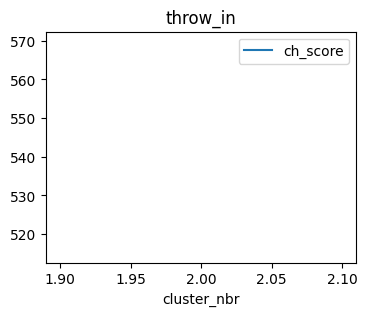

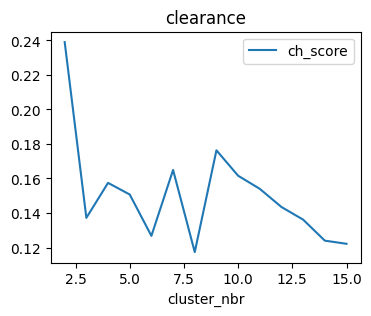

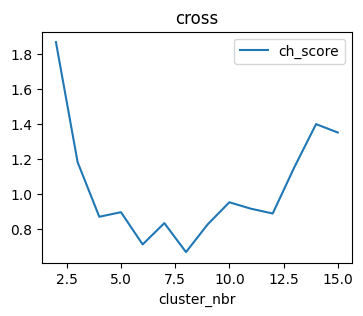

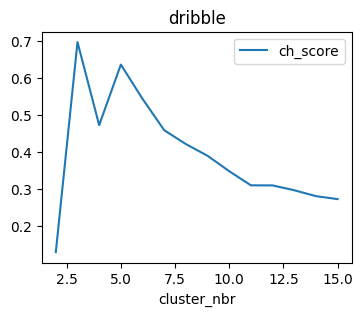

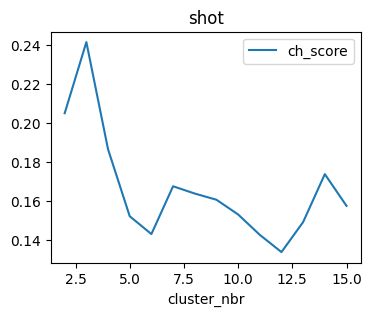

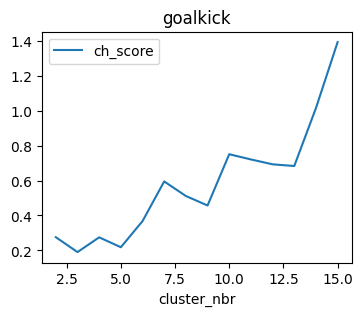

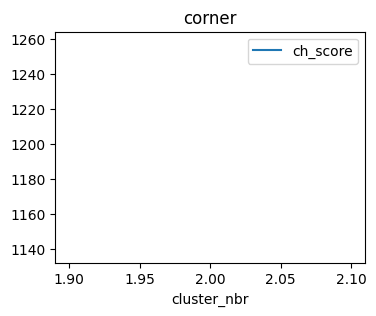

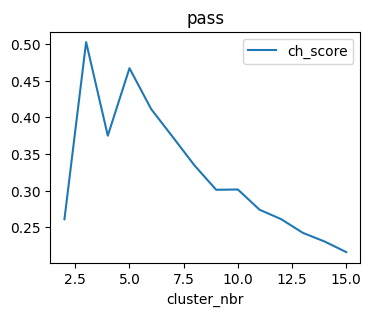

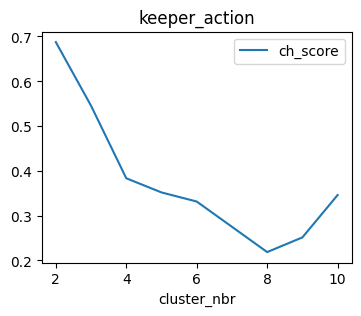

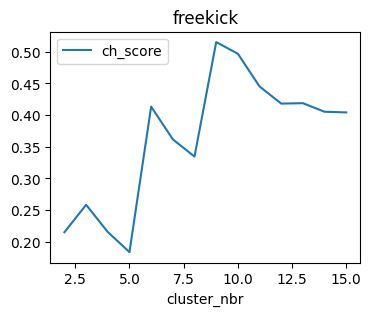

In [245]:
loc_scores_filtered = loc_scores[(loc_scores["ch_score"]<=2_000) & (loc_scores["ch_score"]>0)]
for action_type in action_types:
    loc_scores_filtered[loc_scores_filtered["action_type"]==action_type].plot(
        x="cluster_nbr",
        y="ch_score",
        title=f"{action_type}",
        figsize=(4,3)
    )

In [246]:
optimal_loc_K = {
    f"{action_type}": group.loc[group["ch_score"].idxmax(), "cluster_nbr"]
    for action_type, group in loc_scores_filtered.groupby("action_type")
}
optimal_loc_K

{'clearance': 2,
 'corner': 2,
 'cross': 2,
 'dribble': 3,
 'freekick': 9,
 'goalkick': 15,
 'keeper_action': 2,
 'pass': 3,
 'shot': 3,
 'throw_in': 2}

In [ ]:
optimal_loc_K = {
    'clearance': 2,
    'corner': 2,
    'cross': 2,
    'dribble': 3,
    'freekick': 9,
    'goalkick': 15,
    'keeper_action': 2,
    'pass': 3,
    'shot': 3,
    'throw_in': 2}

In [247]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    loc_K = optimal_loc_K[action_type]
    gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
    loc_model = sc.MixtureModel(gauss_clusters)
    _ = loc_model.fit_em_bregman(loc_data)
    loc_models[action_type] = loc_model

Processing throw_in...
Processing clearance...
Processing cross...
Processing dribble...
Processing shot...
Processing goalkick...
Processing corner...
Processing pass...
Processing keeper_action...
Processing freekick...


In [248]:
print(loc_models["pass"])

MixtureModel(n_clusters=3)
  ├─ (0) w=0.462  MultivariateGaussian(d=2, mean=[51.987 51.959], cov=[[467.347  33.342], [33.342 90.901]])
  ├─ (1) w=0.080  MultivariateGaussian(d=2, mean=[56.735  3.312], cov=[[428.873  -1.498], [-1.498  2.432]])
  └─ (2) w=0.458  MultivariateGaussian(d=2, mean=[49.187 21.529], cov=[[480.236 -46.257], [-46.257 101.322]])


### Direction mixture: Number of cluster calibration for Bregman EM

In [249]:
def dir_calibration(actions, action_types, loc_models):
    rows = []
    for action_type in action_types:
        print(f"\nProcessing {action_type}:")
        mask = (actions["type_name"] == action_type)
        loc_data = actions[mask][["start_x", "start_y"]]
        dir_data = actions[mask][["cos_angle", "sin_angle"]]
        N = loc_data.shape[0]
        loc_model = loc_models[action_type]
        K_loc = loc_model.n_clusters
        # first layer posterior is fixed
        loc_posteriors = loc_model.get_posteriors(loc_data)
        for case in ["bregman","classic", "soccermix"]:
            print(f"   Approach: {case}")
            for loc_cluster in range(K_loc):
                print(f"      Location cluster: {loc_cluster}\n         ",end="")
                for K_dir in range(2,6):
                    print(f"K={K_dir}, ",end="")
                    dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)], None)
                    match case:
                        case "bregman":
                            _ = dir_mixture.fit_em_bregman(dir_data, weight=loc_posteriors[:, loc_cluster])
                        case "classic":
                            _ = dir_mixture.fit_em_classic(dir_data, weight=loc_posteriors[:, loc_cluster])
                        case "soccermix":
                            _ = dir_mixture.fit_em_vonmises_approx(dir_data, weight=loc_posteriors[:, loc_cluster])
                        case _:
                            raise ValueError("Invalid choice")

                    rows.append({
                        "action_type": action_type,
                        "loc_cluster": loc_cluster,
                        "cluster_nbr": K_dir,
                        "model" :      case,
                        "ch_score":    round(dir_mixture.kl_ch_score(dir_data),5),
                        "bic_score" :  round(dir_mixture.bic_score(dir_data),0),
                        "aic_score" :  round(dir_mixture.aic_score(dir_data),0)
                    })
                print("")


    dir_scores = pd.DataFrame(rows)
    return dir_scores

In [250]:
dir_scores = dir_calibration(actions, action_types, loc_models)


Processing throw_in:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: soccermix
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 

Processing clearance:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: soccermix
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 

Processing cross:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
 

In [286]:
best_scores = dir_scores.loc[
    dir_scores.groupby(["action_type", "loc_cluster", "model"])["ch_score"].idxmax()
]
optimal_dir_K = best_scores[["action_type", "loc_cluster", "model", "cluster_nbr"]]
optimal_dir_K

,action_type,loc_cluster,model,cluster_nbr
24,clearance,0,bregman,2
32,clearance,0,classic,2
41,clearance,0,soccermix,3
29,clearance,1,bregman,3
37,clearance,1,classic,3
...,...,...,...,...
8,throw_in,0,classic,2
16,throw_in,0,soccermix,2
4,throw_in,1,bregman,2
12,throw_in,1,classic,2


In [296]:
def dir_second_layer(actions, action_types, loc_models, optimal_dir_K, case):
    dir_models = {}
    for action_type in action_types:
        mask = (actions["type_name"] == action_type)
        loc_data = actions[mask][["start_x", "start_y"]]
        dir_data = actions[mask][["cos_angle", "sin_angle"]]
        #N = loc_data.shape[0]
        loc_model = loc_models[action_type]
        K_loc = loc_model.n_clusters
        # first layer posterior is fixed
        loc_posteriors = loc_model.get_posteriors(loc_data)
        mixture_list = []
        for loc_cluster in range(K_loc):
            K_dir = optimal_dir_K[
                        (optimal_dir_K["action_type"] == action_type) &
                        (optimal_dir_K["loc_cluster"] == loc_cluster) &
                        (optimal_dir_K["model"] == case)]["cluster_nbr"].item()
            dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)], None)
            match case:
                case "bregman":
                    _ = dir_mixture.fit_em_bregman(dir_data, weight=loc_posteriors[:, loc_cluster])
                case "classic":
                    _ = dir_mixture.fit_em_classic(dir_data, weight=loc_posteriors[:, loc_cluster])
                case "soccermix":
                    _ = dir_mixture.fit_em_vonmises_approx(dir_data, weight=loc_posteriors[:, loc_cluster])
                case _:
                    raise ValueError("Invalid choice")

            mixture_list.append(dir_mixture)
        dir_models[action_type] = mixture_list
    return dir_models

In [297]:
case = "bregman"
start = time()
dir_models_bregman = dir_second_layer(actions, action_types, loc_models, optimal_dir_K, case)
time_bregman = time() - start
print(f"Bregman von Mises mixtures running time: {time_bregman:.3f}s")

Bregman von Mises mixtures running time: 15.082s


In [298]:
case = "soccermix"
start = time()
dir_models_soccermix = dir_second_layer(actions, action_types, loc_models, optimal_dir_K, case)
time_soccermix = time() - start
print(f"Soccermix von Mises mixtures running time: {time_soccermix:.3f}s")

Soccermix von Mises mixtures running time: 20.244s


In [299]:
case = "classic"
start = time()
dir_models_classic = dir_second_layer(actions, action_types, loc_models, optimal_dir_K, case)
time_classic = time() - start
print(f"Classical EM approach von Mises mixtures running time: {time_classic:.3f}s")

Classical EM approach von Mises mixtures running time: 53.611s


In [ ]:
optimal_dir_K = {('clearance', 0, 'bregman'): 2,
 ('clearance', 0, 'classic'): 2,
 ('clearance', 0, 'soccermix'): 3,
 ('clearance', 1, 'bregman'): 3,
 ('clearance', 1, 'classic'): 3,
 ('clearance', 1, 'soccermix'): 4,
 ('corner', 0, 'bregman'): 2,
 ('corner', 0, 'classic'): 2,
 ('corner', 0, 'soccermix'): 2,
 ('corner', 1, 'bregman'): 2,
 ('corner', 1, 'classic'): 2,
 ('corner', 1, 'soccermix'): 2,
 ('cross', 0, 'bregman'): 5,
 ('cross', 0, 'classic'): 5,
 ('cross', 0, 'soccermix'): 5,
 ('cross', 1, 'bregman'): 2,
 ('cross', 1, 'classic'): 4,
 ('cross', 1, 'soccermix'): 2,
 ('dribble', 0, 'bregman'): 2,
 ('dribble', 0, 'classic'): 2,
 ('dribble', 0, 'soccermix'): 4,
 ('dribble', 1, 'bregman'): 4,
 ('dribble', 1, 'classic'): 4,
 ('dribble', 1, 'soccermix'): 5,
 ('dribble', 2, 'bregman'): 4,
 ('dribble', 2, 'classic'): 4,
 ('dribble', 2, 'soccermix'): 5,
 ('freekick', 0, 'bregman'): 2,
 ('freekick', 0, 'classic'): 2,
 ('freekick', 0, 'soccermix'): 2,
 ('freekick', 1, 'bregman'): 2,
 ('freekick', 1, 'classic'): 2,
 ('freekick', 1, 'soccermix'): 2,
 ('freekick', 2, 'bregman'): 2,
 ('freekick', 2, 'classic'): 2,
 ('freekick', 2, 'soccermix'): 2,
 ('freekick', 3, 'bregman'): 5,
 ('freekick', 3, 'classic'): 5,
 ('freekick', 3, 'soccermix'): 5,
 ('freekick', 4, 'bregman'): 2,
 ('freekick', 4, 'classic'): 2,
 ('freekick', 4, 'soccermix'): 2,
 ('freekick', 5, 'bregman'): 2,
 ('freekick', 5, 'classic'): 2,
 ('freekick', 5, 'soccermix'): 2,
 ('freekick', 6, 'bregman'): 3,
 ('freekick', 6, 'classic'): 3,
 ('freekick', 6, 'soccermix'): 3,
 ('freekick', 7, 'bregman'): 2,
 ('freekick', 7, 'classic'): 2,
 ('freekick', 7, 'soccermix'): 2,
 ('freekick', 8, 'bregman'): 5,
 ('freekick', 8, 'classic'): 5,
 ('freekick', 8, 'soccermix'): 5,
 ('goalkick', 0, 'bregman'): 3,
 ('goalkick', 0, 'classic'): 3,
 ('goalkick', 0, 'soccermix'): 3,
 ('goalkick', 1, 'bregman'): 4,
 ('goalkick', 1, 'classic'): 4,
 ('goalkick', 1, 'soccermix'): 4,
 ('goalkick', 2, 'bregman'): 2,
 ('goalkick', 2, 'classic'): 2,
 ('goalkick', 2, 'soccermix'): 3,
 ('goalkick', 3, 'bregman'): 2,
 ('goalkick', 3, 'classic'): 2,
 ('goalkick', 3, 'soccermix'): 2,
 ('goalkick', 4, 'bregman'): 4,
 ('goalkick', 4, 'classic'): 3,
 ('goalkick', 4, 'soccermix'): 4,
 ('goalkick', 5, 'bregman'): 2,
 ('goalkick', 5, 'classic'): 2,
 ('goalkick', 5, 'soccermix'): 2,
 ('goalkick', 6, 'bregman'): 3,
 ('goalkick', 6, 'classic'): 3,
 ('goalkick', 6, 'soccermix'): 3,
 ('goalkick', 7, 'bregman'): 2,
 ('goalkick', 7, 'classic'): 2,
 ('goalkick', 7, 'soccermix'): 2,
 ('goalkick', 8, 'bregman'): 4,
 ('goalkick', 8, 'classic'): 3,
 ('goalkick', 8, 'soccermix'): 3,
 ('goalkick', 9, 'bregman'): 2,
 ('goalkick', 9, 'classic'): 2,
 ('goalkick', 9, 'soccermix'): 2,
 ('goalkick', 10, 'bregman'): 4,
 ('goalkick', 10, 'classic'): 4,
 ('goalkick', 10, 'soccermix'): 4,
 ('goalkick', 11, 'bregman'): 2,
 ('goalkick', 11, 'classic'): 2,
 ('goalkick', 11, 'soccermix'): 3,
 ('goalkick', 12, 'bregman'): 2,
 ('goalkick', 12, 'classic'): 2,
 ('goalkick', 12, 'soccermix'): 3,
 ('goalkick', 13, 'bregman'): 3,
 ('goalkick', 13, 'classic'): 3,
 ('goalkick', 13, 'soccermix'): 3,
 ('goalkick', 14, 'bregman'): 2,
 ('goalkick', 14, 'classic'): 2,
 ('goalkick', 14, 'soccermix'): 2,
 ('keeper_action', 0, 'bregman'): 4,
 ('keeper_action', 0, 'classic'): 4,
 ('keeper_action', 0, 'soccermix'): 4,
 ('keeper_action', 1, 'bregman'): 5,
 ('keeper_action', 1, 'classic'): 5,
 ('keeper_action', 1, 'soccermix'): 5,
 ('pass', 0, 'bregman'): 2,
 ('pass', 0, 'classic'): 2,
 ('pass', 0, 'soccermix'): 5,
 ('pass', 1, 'bregman'): 2,
 ('pass', 1, 'classic'): 2,
 ('pass', 1, 'soccermix'): 2,
 ('pass', 2, 'bregman'): 2,
 ('pass', 2, 'classic'): 2,
 ('pass', 2, 'soccermix'): 2,
 ('shot', 0, 'bregman'): 4,
 ('shot', 0, 'classic'): 4,
 ('shot', 0, 'soccermix'): 4,
 ('shot', 1, 'bregman'): 2,
 ('shot', 1, 'classic'): 2,
 ('shot', 1, 'soccermix'): 5,
 ('shot', 2, 'bregman'): 2,
 ('shot', 2, 'classic'): 2,
 ('shot', 2, 'soccermix'): 2,
 ('throw_in', 0, 'bregman'): 2,
 ('throw_in', 0, 'classic'): 2,
 ('throw_in', 0, 'soccermix'): 2,
 ('throw_in', 1, 'bregman'): 2,
 ('throw_in', 1, 'classic'): 2,
 ('throw_in', 1, 'soccermix'): 2}

In [274]:
best_rows.groupby(["action_type","model"])["cluster_nbr"].sum().head

<bound method NDFrame.head of action_type    model    
clearance      bregman       5
               classic       5
               soccermix     7
corner         bregman       4
               classic       4
               soccermix     4
cross          bregman       7
               classic       9
               soccermix     7
dribble        bregman      10
               classic      10
               soccermix    14
freekick       bregman      25
               classic      25
               soccermix    25
goalkick       bregman      41
               classic      39
               soccermix    43
keeper_action  bregman       9
               classic       9
               soccermix     9
pass           bregman       6
               classic       6
               soccermix     9
shot           bregman       8
               classic       8
               soccermix    11
throw_in       bregman       4
               classic       4
               soccermix     4
Name: cluster_n

In [275]:
best_rows[best_rows["cluster_nbr"]==5].head(100)

,action_type,loc_cluster,cluster_nbr,model,ch_score,bic_score,aic_score
51,cross,0,5,bregman,0.011938,28591.394161,28560.433746
59,cross,0,5,classic,0.009897,28536.082236,28505.121821
67,cross,0,5,soccermix,0.013490,28596.848606,28565.888191
103,dribble,1,5,soccermix,0.071821,188534.165680,188480.952099
107,dribble,2,5,soccermix,0.127347,189237.706209,189184.492627
423,freekick,3,5,bregman,0.092497,4514.780658,4483.928439
459,freekick,3,5,classic,0.094302,4514.868542,4484.016323
495,freekick,3,5,soccermix,0.072353,4551.744680,4520.892460
443,freekick,8,5,bregman,0.133025,4649.851135,4618.998916
479,freekick,8,5,classic,0.133839,4648.998043,4618.145823
